Fitting population params so waterfall plot matches the real clinical trial one. Using Model ../final/pca_models/MLPRegressor_600_100_40_11_-7_6.pickle

In [1]:
import numpy as np

POPULATION_SIZE = 100_000
DISTRIBUTION_PARAMETERS = np.array(
    [
        [0.05, 0.5],
        [-2.436, 0.62335],
        [-2.58098, 0.69689],
        [0.2, 0.4],
        [0.005, 0.01],
        [0.01155, 0.0231],
        [0.15, 0.30],
        [150, 300],
        [0.75, 1.5],
        [1e-5, 0.01],
    ]
)
LOGNORMAL_PARAMETERS = (1, 2)

np.random.seed(seed=42)

In [2]:
# Loading model (including scaler, pca, dropping column 0 and transforming orders of magnitue to absolute values)

import time
from sklearn.preprocessing import MinMaxScaler
import pickle
from pathlib import Path


class CustomScaler:
    def __init__(self):
        super().__init__()
        self.scaler = MinMaxScaler()
        self.plot_loval = [0.0] * len(LOGNORMAL_PARAMETERS)
        self.plot_hival = [1.0] * len(LOGNORMAL_PARAMETERS)

    def transform(self, x: np.ndarray, copy=None) -> np.ndarray:
        res = self.scaler.transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = (x[:, parameter_index] - self.plot_loval[i]) / (self.plot_hival[i] - self.plot_loval[i])

        return res

    def fit(self, x, copy=None):
        self.scaler.fit(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            column_values = x[:, parameter_index]

            quantile_1, quantile_3 = np.quantile(column_values, [0.25, 0.75], axis=0)
            iqr = quantile_3 - quantile_1

            loval = quantile_1 - 1.5 * iqr
            hival = quantile_3 + 1.5 * iqr

            wiskhi = np.compress(column_values <= hival, column_values)
            wisklo = np.compress(column_values >= loval, column_values)
            actual_hival = np.max(wiskhi)
            actual_loval = np.min(wisklo)

            self.plot_loval[i] = actual_loval
            self.plot_hival[i] = actual_hival

        return self

    def inverse_transform(self, x, copy=None):
        res = self.scaler.inverse_transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = x[:, parameter_index] * (self.plot_hival[i] - self.plot_loval[i]) + self.plot_loval[i]
        return res
    
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from threadpoolctl import threadpool_limits
from cpuinfo import get_cpu_info
from sklearn.decomposition import PCA


with Path(f"../final/scaler.pickle").open("rb") as scaler_file:
    scaler = pickle.load(scaler_file)

with Path(f"../final/pca/11_-7.pickle").open("rb") as opened_file:
    pca = pickle.load(opened_file)

with Path("../final/pca_models/MLPRegressor_600_100_40_11_-7_6.pickle").open("rb") as opened_file:
    regressor = pickle.load(opened_file)
    
def drop_treatment(input_data: np.ndarray) -> np.ndarray:
    """Drops treatment data from the dataset"""
    if input_data.shape[1] == 11:
        return input_data[:, 1:]

    return input_data

def predict(*args):
    return regressor.predict(*args)

def output_untransform(transformed_outputs: np.array) -> np.array:
    lower_limits = transformed_outputs <= -7
    z = 10 ** transformed_outputs
    z[lower_limits] = 0
    return z

model = make_pipeline(
    FunctionTransformer(drop_treatment),
    scaler,
    FunctionTransformer(predict),
    FunctionTransformer(pca.inverse_transform),
    FunctionTransformer(output_untransform)
)

In [3]:
# Generating parameters for each virtual patient in virtual population
# Note: To get virtual population with different distribution the alredy generated parameters are adjusted to the new distribution.


def generate_patient_indicators(size: int) -> np.ndarray:
    """
    Generates patient indicators.

    :param size: number of patients
    :return:
    """
    patient_indicators_arr = np.zeros((size, 11))
    patient_indicators_arr[:, 0] = np.ones(
        size
    )  # first indicator tells if treatment was applied

    for i, distribution_parameters in enumerate(DISTRIBUTION_PARAMETERS):
        if i in LOGNORMAL_PARAMETERS:
            patient_indicators_arr[:, i + 1] = np.random.lognormal(
                mean=distribution_parameters[0],
                sigma=distribution_parameters[1],
                size=size,
            )
        else:
            patient_indicators_arr[:, i + 1] = np.random.uniform(
                low=distribution_parameters[0],
                high=distribution_parameters[1],
                size=size,
            )

    return patient_indicators_arr

start_time = time.time()
patient_indicators = generate_patient_indicators(POPULATION_SIZE)
patient_indicators_generation_time_s = time.time() - start_time

print(
    f"Generated {POPULATION_SIZE} sets of patients indicators in {patient_indicators_generation_time_s} seconds"
)

Generated 100000 sets of patients indicators in 0.010008096694946289 seconds


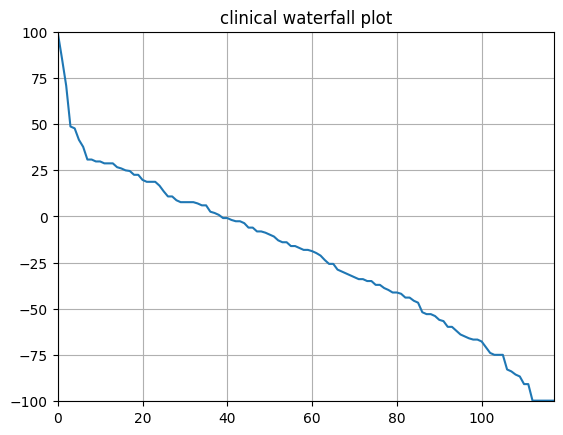

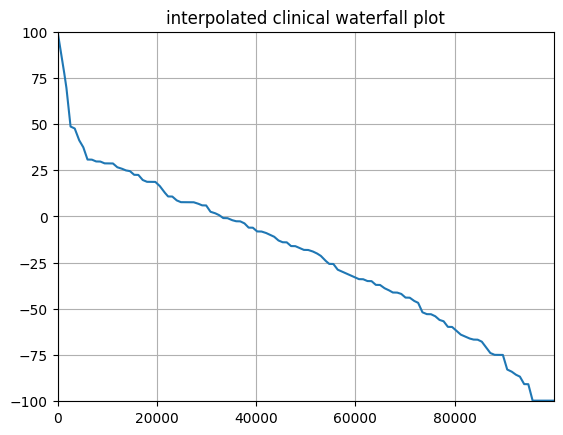

In [4]:
CLINICAL_WATERFALL_PLOT = '../final/Chatterjee_etal_2016_10mgperkg_Waterfall.csv'
population_data = np.loadtxt(CLINICAL_WATERFALL_PLOT, delimiter=",", skiprows=1, usecols=(1,))

import matplotlib.pyplot as plt

plt.title("clinical waterfall plot")
plt.grid()
plt.plot(population_data)
plt.xlim([0, 117])
plt.ylim([-100, 100])
plt.show()


from scipy import interpolate
waterfall_plot_interpolation = interpolate.interp1d(
    np.arange(0, len(population_data)) / (len(population_data) - 1), population_data
)
plt.title("interpolated clinical waterfall plot")
plt.grid()
plt.plot(waterfall_plot_interpolation(np.arange(POPULATION_SIZE) / (POPULATION_SIZE - 1)))
plt.xlim([0, POPULATION_SIZE - 1])
plt.ylim([-100, 100])
plt.show()



In [5]:
class TooManyDroppedCasesError(Exception):
    """Exception raised when too many cases were dropped by the model."""


class InvalidParametersError(Exception):
    """Exception raised when parameters passed to objective function are invalid"""


def validate_params(relative_params):
    for column in range(len(DISTRIBUTION_PARAMETERS)):
        i = column
        if column not in LOGNORMAL_PARAMETERS:
            absolute_params = DISTRIBUTION_PARAMETERS[column]
            low = absolute_params[0] + relative_params[i * 2] * (absolute_params[1] - absolute_params[0])
            high = absolute_params[0] + relative_params[i * 2 + 1] * (absolute_params[1] - absolute_params[0])

            if relative_params[i * 2] < -0.02 or relative_params[i * 2 + 1] > 1.02:
                raise InvalidParametersError(f"{(low, high)} out of range on column {column} ({relative_params[2 * i]}, {relative_params[2 * i + 1]})")

            if relative_params[2 * i] >= relative_params[2 * i + 1]:
                raise InvalidParametersError(f"negative range at column {column} ({relative_params[2 * i]}, {relative_params[2 * i + 1]})")

def initial_relative_params(ratio):
    params = []
    for column in range(len(DISTRIBUTION_PARAMETERS)):
        if column in LOGNORMAL_PARAMETERS:
            params.append(0.0)
            params.append(ratio)
        else:
            params.append(1.0 - ratio)
            params.append(ratio)

    return np.array(params)
                
def adjust_patient_indicators(indicators, relative_params):
    global patient_indicators
    
    for i in range(len(DISTRIBUTION_PARAMETERS)):
        if i in LOGNORMAL_PARAMETERS:
            indicators[:, i + 1] = np.exp(
                (np.log(patient_indicators[:, i + 1]) - DISTRIBUTION_PARAMETERS[i][0])
                * (relative_params[2 * i + 1] / DISTRIBUTION_PARAMETERS[i][1])
                + DISTRIBUTION_PARAMETERS[i][0]
                + relative_params[2 * i]
            )
        else:
            indicators[:, i + 1] = (
                DISTRIBUTION_PARAMETERS[i][0]
                + relative_params[i * 2] * (DISTRIBUTION_PARAMETERS[i][1] - DISTRIBUTION_PARAMETERS[i][0])
                + (relative_params[2 * i + 1] - relative_params[2 * i]) * (patient_indicators[:, i + 1] - DISTRIBUTION_PARAMETERS[i][0])
            )
    return indicators

In [6]:
def waterfall_plot(indicators):
    time_profiles = model.transform(indicators)
    
    max_tumor_sizes = time_profiles.max(axis=1)
    final_tumor_sizes = time_profiles[:, -1]
    final_tumor_sizes[final_tumor_sizes < 0] = 0

    initial_tumor_sizes = indicators[:, 10]
    max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
    percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes

    dropped_count = int(np.sum(max_percent_change > 100.0))
    if dropped_count / POPULATION_SIZE > 0.8:
        raise TooManyDroppedCasesError(f"Dropped {dropped_count} out of {POPULATION_SIZE} ({dropped_count * 100 / POPULATION_SIZE:.2f}%) time profiles")
    percent_change = percent_change[max_percent_change <= 100.0]
    percent_change[::-1].sort()
    
    return percent_change

In [7]:
import time
minimize_history = []
indicators = np.copy(patient_indicators)

def minimize_objective(relative_params, use_regularization=True):
    global minimize_history, indicators
    
    try:
        validate_params(relative_params)
        adjust_patient_indicators(indicators, relative_params)
        
        virtual_waterfall_plot = waterfall_plot(indicators)
        interpolated_waterfall_plot = waterfall_plot_interpolation(np.arange(virtual_waterfall_plot.shape[0]) / (virtual_waterfall_plot.shape[0] - 1))

        regularization_term = 0.5
        regularization = np.power(np.prod([
            regularization_term / min(regularization_term, relative_params[2 * i + 1] - relative_params[2 * i])
            for i in range(len(DISTRIBUTION_PARAMETERS))
            if i not in LOGNORMAL_PARAMETERS
        ]), 1.0/(len(DISTRIBUTION_PARAMETERS) - len(LOGNORMAL_PARAMETERS)))
        
        distance = np.linalg.norm(interpolated_waterfall_plot - virtual_waterfall_plot)
        minimize_history.append((relative_params, regularization * distance, regularization, distance, time.time()))
        # print(f"{len(minimize_history)} d: {distance} r: {regularization} r*d: {regularization*distance}")
    except Exception as err:
        print(str(err))
        minimize_history.append((relative_params, float("inf"), float("inf"), float("inf"), time.time()))
    
    return minimize_history[-1][1 if use_regularization else 3]

def minimize_objective_no_regularization(relative_params):
    return minimize_objective(relative_params, False)

In [8]:
import scipy.optimize
from cpuinfo import get_cpu_info
import json
import math

bounds = scipy.optimize.Bounds(
    lb=[-math.inf if i // 2 in LOGNORMAL_PARAMETERS else -0.02 for i in range(len(DISTRIBUTION_PARAMETERS) * 2)],
    ub=[math.inf if i // 2 in LOGNORMAL_PARAMETERS else 1.02 for i in range(len(DISTRIBUTION_PARAMETERS) * 2)]
)

constraints = [{
    'type': 'ineq',
    'fun': lambda x: [((x[2 * i + 1] - x[2 * i]) if (x[2 * i + 1] != x[2 * i]) else -1) for i in range(len(DISTRIBUTION_PARAMETERS)) if i not in LOGNORMAL_PARAMETERS] 
}]

results = {}
minimize_models = (("Nelder-Mead", ({
        "method": "Nelder-Mead",
        "bounds": bounds,
        "options": {
            "maxiter": 800,
        }
    },)),
    ("Nelder-Mead_adaptive", ({
        "method": "Nelder-Mead",
        "bounds": bounds,
        "options": {
            "maxiter": 600,
            "adaptive": True
        }
    },)),
    ("Nelder-Mead_restart", ({
        "method": "Nelder-Mead",
        "bounds": bounds,
        "options": {
            "maxiter": 350,
            "adaptive": True
        }
    },{
        "method": "Nelder-Mead",
        "bounds": bounds,
        "options": {
            "maxiter": 250,
            "adaptive": True
        }
    },{
        "method": "Nelder-Mead",
        "bounds": bounds,
        "options": {
            "maxiter": 150,
            "adaptive": True
        }
    },{
        "method": "Nelder-Mead",
        "bounds": bounds,
        "options": {
            "maxiter": 100,
            "adaptive": True
        }
    },)),
    ("Powell", ({
        "method": "Powell",
        "bounds": bounds,
        "options": {
            "maxiter": 1000,
        }
    },)),
    ("BFGS", ({
        "method": "BFGS",
        "options": {
            "maxiter": 1000,
        }
    },)),
    ("SLSQP", ({
        "method": "SLSQP",
        "bounds": bounds,
        "constraints": constraints,
        "options": {
            "maxiter": 600,
        }
    },))
        )

for method_name, options_list in minimize_models:
    minimize_path = Path(f"../final/minimize_{method_name}.json")
    if minimize_path.is_file():
        with minimize_path.open("r") as opened_file:
            metadata = json.load(opened_file)
            results[method_name] = metadata["minimize_history"]
        continue

    minimize_history = []
    start_time = time.time()
    
    params = initial_relative_params(0.95)
    result = None
    for options in options_list:
        result = scipy.optimize.minimize(
            minimize_objective,
            params,
            **options,
        )
        params = result.x
    
    results[method_name] = [(p.tolist(), v, v_r, v_d, int(t - start_time)) for p, v, v_r, v_d, t in minimize_history]
    
    with minimize_path.open("w") as opened_file:
        opened_file.write(json.dumps({
            "cpu_info": {key: get_cpu_info()[key] for key in ["arch", "bits", "brand_raw", "count"]},
            "minimize_options": [o["options"] for o in options_list],
            "population_size": POPULATION_SIZE,
            "minimize_history": results[method_name],
            "model": "pca_models/MLPRegressor_600_100_40_11_-7_6.pickle"
        }, sort_keys=True, indent=4))
    

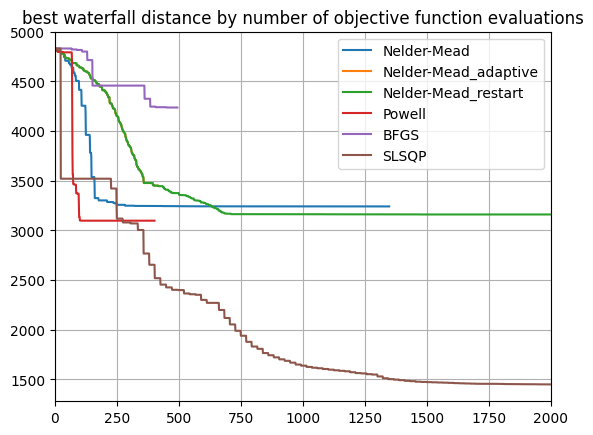

In [9]:
import itertools
import operator

plt.title("best waterfall distance by number of objective function evaluations")
plt.grid()
for method_name in ("Nelder-Mead", "Nelder-Mead_adaptive", "Nelder-Mead_restart", "Powell", "BFGS", "SLSQP"):
    plt.plot(list(itertools.accumulate((x[1] for x in results[method_name]), min)), label=method_name)
plt.legend()
plt.xlim((0, 2000))
plt.show()

In [44]:
# total number of objective function evaluations:

total=0
for method_name in ("Nelder-Mead", "Nelder-Mead_adaptive", "Nelder-Mead_restart", "Powell", "BFGS", "SLSQP"):
    print(f"{method_name}: {len(results[method_name])}")
    total += len(results[method_name])
    
print(f"total: {total}")
    


Nelder-Mead: 1349
Nelder-Mead_adaptive: 416
Nelder-Mead_restart: 2996
Powell: 403
BFGS: 495
SLSQP: 2135
total: 7794


In [10]:
for method_name, options_list in minimize_models:
    method_name = f"no_regularization_{method_name}"
    minimize_path = Path(f"../final/minimize_{method_name}.json")
    if minimize_path.is_file():
        with minimize_path.open("r") as opened_file:
            metadata = json.load(opened_file)
            results[method_name] = metadata["minimize_history"]
        continue

    minimize_history = []
    start_time = time.time()
    
    params = initial_relative_params(0.95)
    result = None
    for options in options_list:
        result = scipy.optimize.minimize(
            minimize_objective_no_regularization,
            params,
            **options,
        )
        params = result.x
    
    results[method_name] = [(p.tolist(), v, v_r, v_d, int(t - start_time)) for p, v, v_r, v_d, t in minimize_history]
    
    with minimize_path.open("w") as opened_file:
        opened_file.write(json.dumps({
            "cpu_info": {key: get_cpu_info()[key] for key in ["arch", "bits", "brand_raw", "count"]},
            "minimize_options": [o["options"] for o in options_list],
            "population_size": POPULATION_SIZE,
            "minimize_history": results[method_name],
            "model": "pca_models/MLPRegressor_600_100_40_11_-7_6.pickle"
        }, sort_keys=True, indent=4))

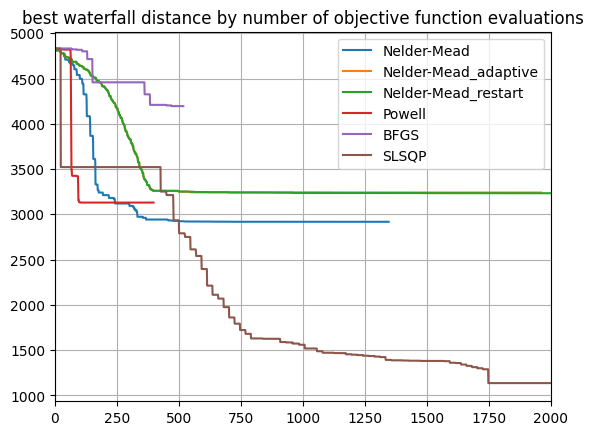

In [11]:
import itertools
import operator

plt.title("best waterfall distance by number of objective function evaluations")
plt.grid()
for method_name in ("Nelder-Mead", "Nelder-Mead_adaptive", "Nelder-Mead_restart", "Powell", "BFGS", "SLSQP"):
    plt.plot(list(itertools.accumulate((x[3] for x in results["no_regularization_" + method_name]), min)), label=method_name)
plt.legend()
plt.xlim((0, 2000))
plt.show()

In [31]:
# Calculating waterfall plot by qsp model with original parameters

from pathlib import Path

MODEL_PATH = Path("../qspRPlusC/simulateQSP.R").resolve()

# importing model
import os
from contextlib import redirect_stderr, redirect_stdout
from io import StringIO

from multiprocess import Process, Queue, cpu_count

from rpy2 import robjects
from rpy2.rinterface_lib.embedded import RRuntimeError
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage


END_VALUE = "end"


def load_r_model():
    """Loads R model from file and returns it as a python object."""
    model_path = MODEL_PATH
    cur_dir = Path.cwd()
    try:
        os.chdir(model_path.parent)
        with model_path.open("r") as f_p:
            model = SignatureTranslatedAnonymousPackage(f_p.read(), "model")
    finally:
        os.chdir(cur_dir)
    return model

r_model = load_r_model()

def calc_model_point(coord):
    global r_model
    stream = StringIO()
    err_stream = StringIO()
    try:
        with redirect_stdout(stream), redirect_stderr(err_stream):
            res = r_model.simulateQSP(robjects.FloatVector(coord))[0]
    except RRuntimeError as r_exception:
        raise ValueError(f"Error in simulation {r_exception.args[0]}") from r_exception
    stream.seek(0)
    err_stream.seek(0)
    if stream.read() or err_stream.read():
        raise ValueError("Unstable simulation")
    index = list(res.names).index("Tumor_volume")
    return list(res[index])

def calc_model_point_mp(in_queue: Queue, out_queue: Queue):
    stream = StringIO()
    err_stream = StringIO()
    try:
        with redirect_stdout(stream), redirect_stderr(err_stream):
            r_model = load_r_model()
    except (RRuntimeError, FileNotFoundError) as e:
        out_queue.put((None, e))
        raise

    while True:
        input_data = in_queue.get()
        if input_data == END_VALUE:
            return

        i, coord = input_data
        try:
            res = calc_model_point(coord)
            out_queue.put((i, res))
        except ValueError as e:
            print(f"unstable {i}")
            res = [coord[10], *([100.0 * coord[10]] * 199)]
            out_queue.put((i, res))


def collect_result(
    out_queue: Queue, tumor_time_profiles: np.ndarray, progress_bar=None
):
    ind, data_row = out_queue.get(timeout=60)
    if ind is None:
        raise RuntimeError("Loading model fails") from data_row
    tumor_time_profiles[ind, :] = data_row
    if progress_bar is not None:
        progress_bar.update(1)


def model_predict_with_progress(input_data, progress_bar) -> np.array:
    print(f"calculating time profiles for {input_data.shape[0]} patients indicators")
    
    in_queue = Queue()
    out_queue = Queue()
    process_list = []
    process_num = cpu_count()

    for _ in range(process_num):
        proc = Process(target=calc_model_point_mp, args=(in_queue, out_queue))
        proc.start()
        process_list.append(proc)

    res_time_profiles = np.empty((input_data.shape[0], 200))
    calculated = 0

    try:
        for i, coord in enumerate(input_data):
            in_queue.put((i, coord))

            if i > 10 * process_num:
                collect_result(out_queue, res_time_profiles, progress_bar)
                calculated += 1

        while calculated < input_data.shape[0]:
            collect_result(out_queue, res_time_profiles, progress_bar)
            calculated += 1
    finally:
        for _ in range(process_num):
            in_queue.put(END_VALUE)

        for i in range(process_num):
            process_list[i].join()
    
    return res_time_profiles
            
from tqdm.notebook import tqdm

real_unoptimized_time_profiles = None
indicators = np.copy(patient_indicators)
with tqdm(total=indicators.shape[0]) as pbar:
    time_profiles = model_predict_with_progress(indicators, pbar)
    real_unoptimized_time_profiles = time_profiles[time_profiles[:, 0] * 100.0 != time_profiles[:, 1], :]
    
print(f"calculated {real_unoptimized_time_profiles.shape}")

make: Nothing to be done for `all'.


using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’


  0%|          | 0/100000 [00:00<?, ?it/s]

calculating time profiles for 100000 patients indicators


using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’
using SDK: ‘MacOSX13.3.sdk’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’
using SDK: ‘MacOSX13.3.sdk’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’
using SDK: ‘MacOSX13.3.sdk’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’
using 

make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.


using SDK: ‘MacOSX13.3.sdk’


unstable 69
unstable 86
unstable 240
unstable 257
unstable 660
unstable 748
unstable 763
unstable 1103
unstable 1117
unstable 1223
unstable 1245
unstable 1443
unstable 1456
unstable 1649
unstable 1785
unstable 1830
unstable 2016
unstable 2278
unstable 2387
unstable 2716
unstable 3225
unstable 3402
unstable 3672
unstable 3713
unstable 4509
unstable 4635
unstable 4662
unstable 4811
unstable 4831
unstable 5185
unstable 5273
unstable 5483
unstable 5753
unstable 5907
unstable 6530
unstable 6627
unstable 6698
unstable 6790
unstable 7099
unstable 7162
unstable 7428
unstable 7497
unstable 7645
unstable 7875
unstable 7903
unstable 7954
unstable 8550
unstable 8776
unstable 8959
unstable 9050
unstable 9078
unstable 9192
unstable 9507
unstable 9596
unstable 9966
unstable 10102
unstable 10178
unstable 10581
unstable 10847
unstable 10865
unstable 10990
unstable 11438
unstable 11499
unstable 11831
unstable 11920
unstable 11953
unstable 12278
unstable 12621
unstable 12728
unstable 13011
unstable 13038

In [33]:
# Calculating waterfall plot by qsp model with optimized parameters

optimized_indicators = np.copy(patient_indicators)
best_params = results["SLSQP"][0]
for p in results["SLSQP"]:
    if best_params[1] > p[1]:
        best_params = p
        
adjust_patient_indicators(optimized_indicators, best_params[0])

real_time_profiles = None
with tqdm(total=optimized_indicators.shape[0]) as pbar:
    time_profiles = model_predict_with_progress(optimized_indicators, pbar)
    real_time_profiles = time_profiles[time_profiles[:, 0] * 100.0 != time_profiles[:, 1], :]
    
print(f"calculated {real_time_profiles.shape}")

  0%|          | 0/100000 [00:00<?, ?it/s]

calculating time profiles for 100000 patients indicators
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.
make: Nothing to be done for `all'.


using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’
using SDK: ‘MacOSX13.3.sdk’
using SDK: ‘MacOSX13.3.sdk’
using SDK: ‘MacOSX13.3.sdk’
using C compiler: ‘Apple clang version 14.0.3 (clang-1403.0.22.14.1)’
using SDK: ‘MacOSX13.3.sdk’
using C compiler: ‘Apple clang version 14.0.3 (c

calculated (100000, 200)


In [36]:
def interpolated_waterfall_plot(time_profiles, size):
    max_tumor_sizes = time_profiles.max(axis=1)
    final_tumor_sizes = time_profiles[:, -1]
    final_tumor_sizes[final_tumor_sizes < 0] = 0
    initial_tumor_sizes = time_profiles[:, 0]
    r_percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
    max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
    r_percent_change = r_percent_change[max_percent_change <= 100.0]
    r_percent_change[::-1].sort()
    r_percent_change_interpolation = interpolate.interp1d(
        np.arange(0, len(r_percent_change)) / (len(r_percent_change) - 1), r_percent_change
    )
    return r_percent_change_interpolation(np.arange(size) / (size - 1))

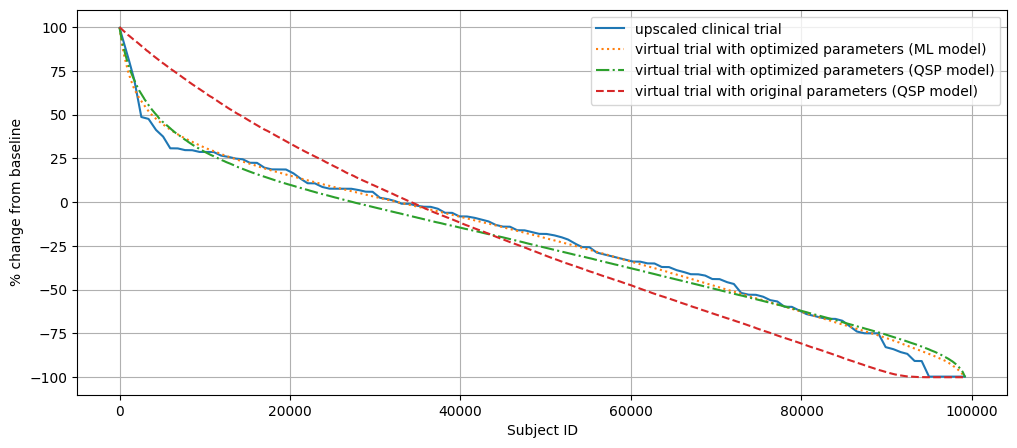

In [42]:
ml_optimized_waterfall_plot = waterfall_plot(optimized_indicators)
waterfall_plot_width = ml_optimized_waterfall_plot.shape[0]
clinical_waterfall_plot = waterfall_plot_interpolation(np.arange(waterfall_plot_width) / (waterfall_plot_width - 1))
qsp_optimized_waterfall_plot = interpolated_waterfall_plot(real_time_profiles, waterfall_plot_width)
qsp_waterfall_plot = interpolated_waterfall_plot(real_unoptimized_time_profiles, waterfall_plot_width)


plt.figure(figsize=(12,5))
plt.grid()
plt.xlabel("Subject ID")
plt.ylabel("% change from baseline")

plt.plot(clinical_waterfall_plot, label="upscaled clinical trial")
plt.plot(ml_optimized_waterfall_plot, label="virtual trial with optimized parameters (ML model)", linestyle='dotted')
plt.plot(qsp_optimized_waterfall_plot, label="virtual trial with optimized parameters (QSP model)", linestyle='dashdot')
plt.plot(qsp_waterfall_plot, label="virtual trial with original parameters (QSP model)", linestyle='--')

plt.legend()

plt.show()

In [43]:
from scipy.stats import kstest

print(f"ks test virtual trial with optimized parameters: {kstest(population_data, qsp_optimized_waterfall_plot, method='exact')}")
print(f"ks test virtual trial with original parameters: {kstest(population_data, qsp_waterfall_plot, method='exact')}")

ks test virtual trial with optimized parameters: KstestResult(statistic=0.07560425890390127, pvalue=0.4873143863442581, statistic_location=-18.760976006960473, statistic_sign=-1)
ks test virtual trial with original parameters: KstestResult(statistic=0.15284653148126948, pvalue=0.007191860815986612, statistic_location=30.80895009, statistic_sign=1)
